# CGan: 채색 모델
---

## 1. 데이터 준비하기

In [47]:
import os

data_path = os.getenv('HOME') + '/project/aiffel/e/e24/cityscapes/train/'
test_path = os.getenv('HOME') + '/project/aiffel/e/e24/cityscapes/val/'
print('number of train examples: ', len(os.listdir(data_path)))
print('number of test exampels:', len(os.listdir(test_path)))

number of train examples:  1000
number of test exampels: 5


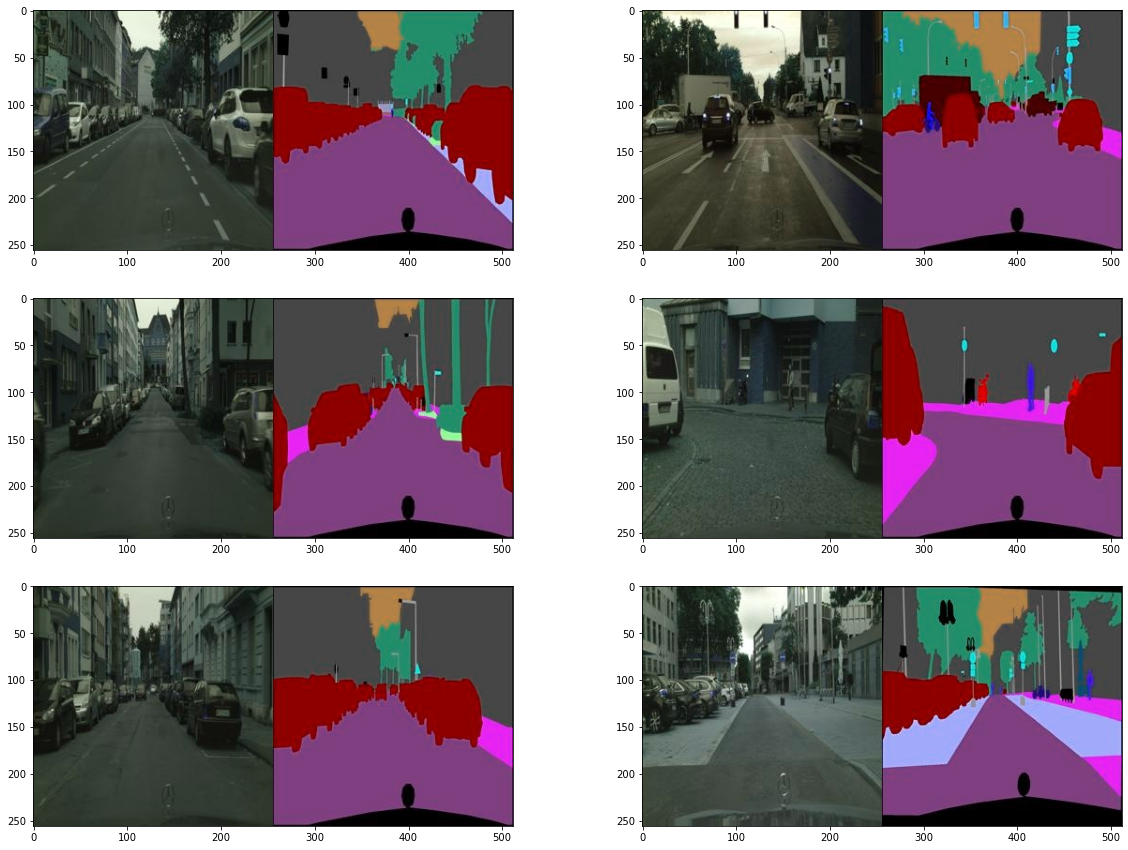

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용한다

In [4]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

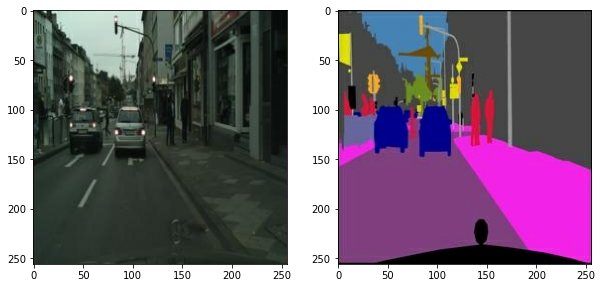

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w  = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1); plt.imshow(denormalize(sketch))
plt.subplot(1, 2, 2); plt.imshow(denormalize(colored))

### Augmentation
- 두 이미지를 연결
- 50% 확률로 Refection padding 이나 Constant padding 이 30픽셀만큼 적용
- 위의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라냄
- 위의 결과에서 50%확률로 좌우반전
- 위의 결과에서 50%확률로 상하반전
- 위의 결과에서 50%확률로 회전

In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, 'REFLECT')
    else:
        padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)
    
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,: 3], out[..., 3:]  

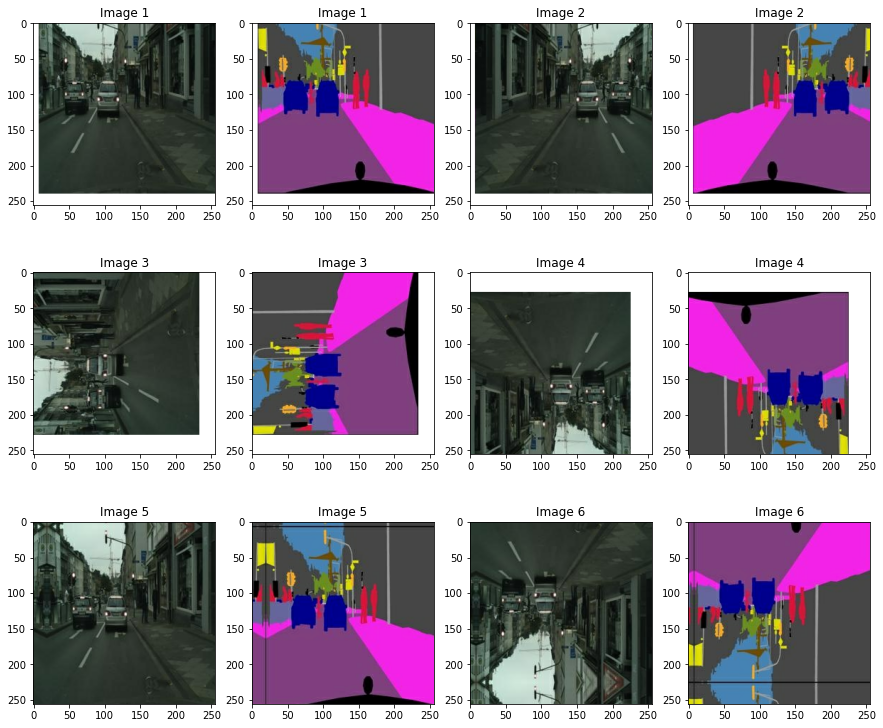

In [7]:
plt.figure(figsize=(15, 13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f'Image {img_n}')
    plt.subplot(3, 4, i+1)
    plt.imshow(denormalize(augmented_colored)); plt.title(f'Image {img_n}')
    img_n += 1

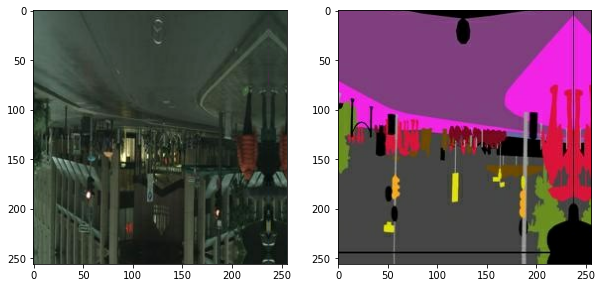

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + '*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1) * 127.5, (sample[0][1]+1) * 127.5

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2. 모델 설계하기

### Generator: Encoder

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, 'same', use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [10]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
            
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

### Generator: Decoder

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, 'same', use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i<3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, 'same', use_bias=False))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

### Generator

In [17]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
Generator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### UNet-Generator

In [21]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
            
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
            
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [22]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

### Discriminator

In [31]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, 'valid', use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, 'same', use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
    
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else: 
            x = self.conv(x)
        
        if self.use_bn:
            x = self.batchnorm(x)
        
        if self.act:
            x = self.lrelu(x)
        return x

In [32]:
inputs = Input((128, 128, 32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, 'valid', use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_47 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [33]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation('sigmoid')
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256, 256, 3), y_shape=(256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [34]:
Discriminator().get_summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block_1 (DiscBlock)        (None, 128, 128, 64) 6144        concatenate_9[0][0]  

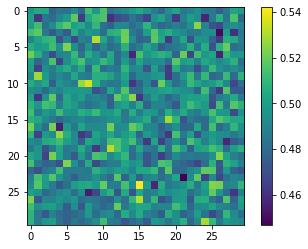

In [35]:
x = tf.random.normal([1, 256, 256, 3])
y = tf.random.normal([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ..., 0])
plt.colorbar()

## 3. 모델 학습 및 테스트

### 손실 함수

In [39]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

### Optimizer

In [40]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

### train_step

In [43]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Genertaor 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## l1 손실 반영 == 100
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

### 학습 진행

In [44]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        if (i+1) % 10 == 0:
            print(f'EPOCH[{epoch}] - STEP[{i+1}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f}\
            \nDiscriminator_loss:{d_loss.numpy():.4f}', end='\n\n')

EPOCH[1] - STEP[10]             
Generator_loss:0.9234             
L1_loss:0.3446            
Discriminator_loss:1.2718

EPOCH[1] - STEP[20]             
Generator_loss:1.0789             
L1_loss:0.2592            
Discriminator_loss:1.1422

EPOCH[1] - STEP[30]             
Generator_loss:1.2923             
L1_loss:0.3013            
Discriminator_loss:0.8102

EPOCH[1] - STEP[40]             
Generator_loss:1.6133             
L1_loss:0.2850            
Discriminator_loss:0.6985

EPOCH[1] - STEP[50]             
Generator_loss:1.8271             
L1_loss:0.2588            
Discriminator_loss:0.5319

EPOCH[1] - STEP[60]             
Generator_loss:1.7347             
L1_loss:0.2415            
Discriminator_loss:0.4554

EPOCH[1] - STEP[70]             
Generator_loss:1.8778             
L1_loss:0.2439            
Discriminator_loss:0.7299

EPOCH[1] - STEP[80]             
Generator_loss:1.6068             
L1_loss:0.2247            
Discriminator_loss:0.5586

EPOCH[1] - STEP[90]     

EPOCH[3] - STEP[180]             
Generator_loss:2.7359             
L1_loss:0.2102            
Discriminator_loss:1.7601

EPOCH[3] - STEP[190]             
Generator_loss:1.5210             
L1_loss:0.1684            
Discriminator_loss:1.9494

EPOCH[3] - STEP[200]             
Generator_loss:2.5972             
L1_loss:0.1742            
Discriminator_loss:1.7440

EPOCH[3] - STEP[210]             
Generator_loss:1.2732             
L1_loss:0.2738            
Discriminator_loss:0.4616

EPOCH[3] - STEP[220]             
Generator_loss:1.6241             
L1_loss:0.2463            
Discriminator_loss:0.6518

EPOCH[3] - STEP[230]             
Generator_loss:2.7287             
L1_loss:0.2097            
Discriminator_loss:0.4581

EPOCH[3] - STEP[240]             
Generator_loss:1.6510             
L1_loss:0.2156            
Discriminator_loss:0.6398

EPOCH[3] - STEP[250]             
Generator_loss:0.8231             
L1_loss:0.1800            
Discriminator_loss:0.7953

EPOCH[4] - STEP[

EPOCH[6] - STEP[100]             
Generator_loss:1.7664             
L1_loss:0.2400            
Discriminator_loss:0.8248

EPOCH[6] - STEP[110]             
Generator_loss:1.1984             
L1_loss:0.1655            
Discriminator_loss:0.8385

EPOCH[6] - STEP[120]             
Generator_loss:0.7641             
L1_loss:0.2090            
Discriminator_loss:0.8691

EPOCH[6] - STEP[130]             
Generator_loss:1.1306             
L1_loss:0.1734            
Discriminator_loss:0.7948

EPOCH[6] - STEP[140]             
Generator_loss:1.1491             
L1_loss:0.2212            
Discriminator_loss:0.6030

EPOCH[6] - STEP[150]             
Generator_loss:1.8271             
L1_loss:0.2114            
Discriminator_loss:0.4671

EPOCH[6] - STEP[160]             
Generator_loss:1.7787             
L1_loss:0.1676            
Discriminator_loss:0.6142

EPOCH[6] - STEP[170]             
Generator_loss:3.2829             
L1_loss:0.1709            
Discriminator_loss:0.8700

EPOCH[6] - STEP[

EPOCH[9] - STEP[20]             
Generator_loss:3.1304             
L1_loss:0.1936            
Discriminator_loss:0.5082

EPOCH[9] - STEP[30]             
Generator_loss:2.5080             
L1_loss:0.1671            
Discriminator_loss:0.2755

EPOCH[9] - STEP[40]             
Generator_loss:2.7321             
L1_loss:0.1690            
Discriminator_loss:1.4072

EPOCH[9] - STEP[50]             
Generator_loss:0.9406             
L1_loss:0.1774            
Discriminator_loss:0.9361

EPOCH[9] - STEP[60]             
Generator_loss:0.8269             
L1_loss:0.1834            
Discriminator_loss:0.7588

EPOCH[9] - STEP[70]             
Generator_loss:2.0924             
L1_loss:0.1456            
Discriminator_loss:0.4573

EPOCH[9] - STEP[80]             
Generator_loss:1.2237             
L1_loss:0.1901            
Discriminator_loss:0.9134

EPOCH[9] - STEP[90]             
Generator_loss:1.9627             
L1_loss:0.1674            
Discriminator_loss:0.4246

EPOCH[9] - STEP[100]    

### 테스트

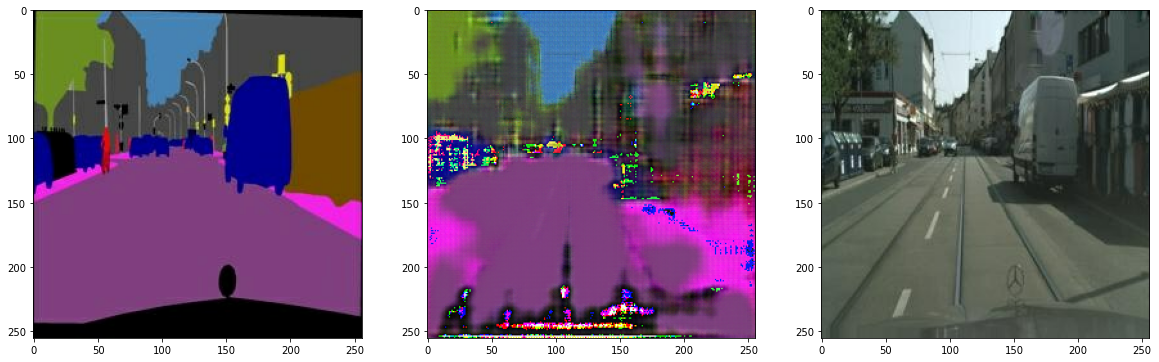

In [49]:
test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1); plt.imshow(denormalize(colored))
plt.subplot(1, 3, 2); plt.imshow(pred[0])
plt.subplot(1, 3, 3); plt.imshow(denormalize(sketch))